In [1]:
'''
author:     Felix Hol
date:       28 Nov 2018
content:    Synonymous vs. non-synonymous SNV analysis of DENV single cell data
'''

from pysam import VariantFile
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from scipy.optimize import curve_fit
from scipy.misc import factorial
import scipy
from scipy import stats
import Bio
from Bio import SeqIO
from Bio.Data import CodonTable
import warnings
warnings.filterwarnings(action='once')
standard_table = CodonTable.unambiguous_dna_by_name["Standard"]

In [2]:
%store -r metadataD
%store -r depth_df48
%store -r depth_df24
%store -r depth_df12
%store -r depth_df48_2
%store -r depth_df24_2
%store -r depth_df12_2
%store -r depth_df4_2
%store -r SNVp

In [3]:
aaDict = standard_table.forward_table
print(standard_table)

Table 1 Standard, SGC0

  |  T      |  C      |  A      |  G      |
--+---------+---------+---------+---------+--
T | TTT F   | TCT S   | TAT Y   | TGT C   | T
T | TTC F   | TCC S   | TAC Y   | TGC C   | C
T | TTA L   | TCA S   | TAA Stop| TGA Stop| A
T | TTG L(s)| TCG S   | TAG Stop| TGG W   | G
--+---------+---------+---------+---------+--
C | CTT L   | CCT P   | CAT H   | CGT R   | T
C | CTC L   | CCC P   | CAC H   | CGC R   | C
C | CTA L   | CCA P   | CAA Q   | CGA R   | A
C | CTG L(s)| CCG P   | CAG Q   | CGG R   | G
--+---------+---------+---------+---------+--
A | ATT I   | ACT T   | AAT N   | AGT S   | T
A | ATC I   | ACC T   | AAC N   | AGC S   | C
A | ATA I   | ACA T   | AAA K   | AGA R   | A
A | ATG M(s)| ACG T   | AAG K   | AGG R   | G
--+---------+---------+---------+---------+--
G | GTT V   | GCT A   | GAT D   | GGT G   | T
G | GTC V   | GCC A   | GAC D   | GGC G   | C
G | GTA V   | GCA A   | GAA E   | GGA G   | A
G | GTG V   | GCG A   | GAG E   | GGG G   | G
--+---------

In [4]:
def synNonSyn (varF, start, stop):
    
    numSyn = 0
    numNonSyn = 0
    numStop = 0
    startPos = 96 ### subtract 1 of real startPos as python is base 0
    aaDict = standard_table.forward_table
    startMin1 = start - 1
    stopMin1 = stop - 1

    for seqD in SeqIO.parse("/Users/felix/Documents/arbovirusGenetics/DENV_ZIKV_singelCell/pySamProcessing/DENV2.fasta", "fasta"):
        seqD.seq

### full ORF 96 - 10274
    
    for rec in varF.fetch() or []:
#         print(rec.pos)
        if rec.pos > startMin1 and rec.pos < stopMin1 and rec.pos not in SNVp.pos.values:
            if (rec.pos - startPos) % 3 == 1:
                refCodon = seqD.seq[rec.pos-1 : rec.pos+2]
                altCodon = rec.alts[0] + refCodon[1:3]
            elif (rec.pos - startPos) % 3 == 2:
                refCodon = seqD.seq[rec.pos-2 : rec.pos+1]
                altCodon = refCodon[0] + rec.alts[0] + refCodon[2]
            elif (rec.pos - startPos) % 3 == 0:
                refCodon = seqD.seq[rec.pos-3 : rec.pos]
                altCodon = refCodon[0:2] + rec.alts[0]
            else:
                print('congrats, you made a new codon')
                
            if refCodon[0:3] == 'TAA' or refCodon[0:3] == 'TAG' or refCodon[0:3] == 'TGA':
                print('I cant believe it, a stop codon in the middel of the coding sequence', rec.pos)

            if altCodon[0:3] != 'TAA' and altCodon[0:3] != 'TAG' and altCodon[0:3] !=  'TGA':
                if aaDict[refCodon[0:3]] == aaDict[altCodon[0:3]]:
                    numSyn = numSyn + 1
                elif aaDict[refCodon[0:3]] != aaDict[altCodon[0:3]]:
                    numNonSyn = numNonSyn + 1
                else:
                    numNonSyn = numNonSyn + 1
                    print('i dont get this')
            
            elif altCodon[0:3] == 'TAA' or altCodon[0:3] == 'TAG' or altCodon[0:3] == 'TGA':
                numStop = numStop + 1
                
    return numSyn, numNonSyn, numStop
            

In [24]:
### Generate dataframes with synonymous and non-synonymous SNVs and calculate Dn/Ds.
### A dataframe for the whole genome is generated and one for each gene. 

'''Anchored capsid C: 97 - 438
Membrane glycoprotein precursor M: 439 - 936
E: 937 - 2421
NS1: 2422 - 3477
NS2a: 3478 - 4131
NS2b: 4132 - 4521
NS3: 4522 - 6375
NS4a: 6376 - 6756
2k: 6757 - 6825
NS4b: 6826 - 7569
NS5: 7570 - 10269
'''

dataDir = "/Users/felix/Documents/arbovirusGenetics/DENV_ZIKV_singelCell/pySamProcessing/vcffilesDENV01"
os.chdir(dataDir)
filenames = glob.glob('*.vcf')

df_SynNonSynAll = pd.DataFrame(columns=['name', 'ID', 'numSyn', 'numNonSyn', 'numStop', 'Ds', 'Dn', 'Dn_s'])
df_SynNonSynC = pd.DataFrame(columns=['ID', 'numSyn', 'numNonSyn', 'numStop', 'Ds', 'Dn', 'Dn_s'])
df_SynNonSynM = pd.DataFrame(columns=['ID', 'numSyn', 'numNonSyn', 'numStop', 'Ds', 'Dn', 'Dn_s'])
df_SynNonSynE = pd.DataFrame(columns=['ID', 'numSyn', 'numNonSyn', 'numStop', 'Ds', 'Dn', 'Dn_s'])
df_SynNonSynNS1 = pd.DataFrame(columns=['ID', 'numSyn', 'numNonSyn', 'numStop', 'Ds', 'Dn', 'Dn_s'])
df_SynNonSynNS2a = pd.DataFrame(columns=['ID', 'numSyn', 'numNonSyn', 'numStop', 'Ds', 'Dn', 'Dn_s'])
df_SynNonSynNS2b = pd.DataFrame(columns=['ID', 'numSyn', 'numNonSyn', 'numStop', 'Ds', 'Dn', 'Dn_s'])
df_SynNonSynNS3 = pd.DataFrame(columns=['ID', 'numSyn', 'numNonSyn', 'numStop', 'Ds', 'Dn', 'Dn_s'])
df_SynNonSynNS4a = pd.DataFrame(columns=['ID', 'numSyn', 'numNonSyn', 'numStop', 'Ds', 'Dn', 'Dn_s'])
df_SynNonSyn2k = pd.DataFrame(columns=['ID', 'numSyn', 'numNonSyn', 'numStop', 'Ds', 'Dn', 'Dn_s'])
df_SynNonSynNS4b = pd.DataFrame(columns=['ID', 'numSyn', 'numNonSyn', 'numStop', 'Ds', 'Dn', 'Dn_s'])
df_SynNonSynNS5 = pd.DataFrame(columns=['ID', 'numSyn', 'numNonSyn', 'numStop', 'Ds', 'Dn', 'Dn_s'])

for i in filenames:
    varFile = VariantFile(i)
    vF = varFile.fetch()
    numSyn, numNonSyn, numStop = synNonSyn(vF, 97, 10269)
    Ds = (-3/4)*np.log(1 - ((4*numSyn/2193.667)/3))
    Dn = (-3/4)*np.log(1 - ((4*numNonSyn/7982.333)/3))
    Dn_s = Dn / Ds
    df_SynNonSynAll = df_SynNonSynAll.append({'name': i[4:-4], 'ID': i, 'numSyn': numSyn, 'numNonSyn': numNonSyn,\
                                        'numStop': numStop, 'Ds': Ds, 'Dn': Dn, 'Dn_s': Dn_s}, ignore_index=True)

dfSynAll_C = df_SynNonSynAll.loc[df_SynNonSynAll['numSyn'] > 0]

for i in filenames:
    varFile = VariantFile(i)
    vF = varFile.fetch()
    numSyn, numNonSyn, numStop = synNonSyn(vF, 97, 438)
    Ds = (-3/4)*np.log(1 - ((4*numSyn/2193.667)/3))
    Dn = (-3/4)*np.log(1 - ((4*numNonSyn/7982.333)/3))
    Dn_s = Dn / Ds
    df_SynNonSynC = df_SynNonSynC.append({'ID': i, 'numSyn': numSyn, 'numNonSyn': numNonSyn,\
                                        'numStop': numStop, 'Ds': Ds, 'Dn': Dn, 'Dn_s': Dn_s}, ignore_index=True)

dfSynC_C = df_SynNonSynC.loc[df_SynNonSynC['numSyn'] > 0]

for i in filenames:
    varFile = VariantFile(i)
    vF = varFile.fetch()
    numSyn, numNonSyn, numStop = synNonSyn(vF, 439, 936)
    Ds = (-3/4)*np.log(1 - ((4*numSyn/2193.667)/3))
    Dn = (-3/4)*np.log(1 - ((4*numNonSyn/7982.333)/3))
    Dn_s = Dn / Ds
    df_SynNonSynM = df_SynNonSynM.append({'ID': i, 'numSyn': numSyn, 'numNonSyn': numNonSyn,\
                                        'numStop': numStop, 'Ds': Ds, 'Dn': Dn, 'Dn_s': Dn_s}, ignore_index=True)

dfSynM_C = df_SynNonSynM.loc[df_SynNonSynM['numSyn'] > 0]

for i in filenames:
    varFile = VariantFile(i)
    vF = varFile.fetch()
    numSyn, numNonSyn, numStop = synNonSyn(vF, 937, 2421)
    Ds = (-3/4)*np.log(1 - ((4*numSyn/2193.667)/3))
    Dn = (-3/4)*np.log(1 - ((4*numNonSyn/7982.333)/3))
    Dn_s = Dn / Ds
    df_SynNonSynE = df_SynNonSynE.append({'ID': i, 'numSyn': numSyn, 'numNonSyn': numNonSyn,\
                                        'numStop': numStop, 'Ds': Ds, 'Dn': Dn, 'Dn_s': Dn_s}, ignore_index=True)

dfSynE_C = df_SynNonSynE.loc[df_SynNonSynE['numSyn'] > 0]

for i in filenames:
    varFile = VariantFile(i)
    vF = varFile.fetch()
    numSyn, numNonSyn, numStop = synNonSyn(vF, 2422, 3477)
    Ds = (-3/4)*np.log(1 - ((4*numSyn/2193.667)/3))
    Dn = (-3/4)*np.log(1 - ((4*numNonSyn/7982.333)/3))
    Dn_s = Dn / Ds
    df_SynNonSynNS1 = df_SynNonSynNS1.append({'ID': i, 'numSyn': numSyn, 'numNonSyn': numNonSyn,\
                                        'numStop': numStop, 'Ds': Ds, 'Dn': Dn, 'Dn_s': Dn_s}, ignore_index=True)

dfSynNS1_C = df_SynNonSynNS1.loc[df_SynNonSynNS1['numSyn'] > 0]

for i in filenames:
    varFile = VariantFile(i)
    vF = varFile.fetch()
    numSyn, numNonSyn, numStop = synNonSyn(vF, 3478, 4131)
    Ds = (-3/4)*np.log(1 - ((4*numSyn/2193.667)/3))
    Dn = (-3/4)*np.log(1 - ((4*numNonSyn/7982.333)/3))
    Dn_s = Dn / Ds
    df_SynNonSynNS2a = df_SynNonSynNS2a.append({'ID': i, 'numSyn': numSyn, 'numNonSyn': numNonSyn,\
                                        'numStop': numStop, 'Ds': Ds, 'Dn': Dn, 'Dn_s': Dn_s}, ignore_index=True)

dfSynNS2a_C = df_SynNonSynNS2a.loc[df_SynNonSynNS2a['numSyn'] > 0]

for i in filenames:
    varFile = VariantFile(i)
    vF = varFile.fetch()
    numSyn, numNonSyn, numStop = synNonSyn(vF, 4132, 4521)
    Ds = (-3/4)*np.log(1 - ((4*numSyn/2193.667)/3))
    Dn = (-3/4)*np.log(1 - ((4*numNonSyn/7982.333)/3))
    Dn_s = Dn / Ds
    df_SynNonSynNS2b = df_SynNonSynNS2b.append({'ID': i, 'numSyn': numSyn, 'numNonSyn': numNonSyn,\
                                        'numStop': numStop, 'Ds': Ds, 'Dn': Dn, 'Dn_s': Dn_s}, ignore_index=True)

dfSynNS2b_C = df_SynNonSynNS2b.loc[df_SynNonSynNS2b['numSyn'] > 0]

for i in filenames:
    varFile = VariantFile(i)
    vF = varFile.fetch()
    numSyn, numNonSyn, numStop = synNonSyn(vF, 4522, 6375)
    Ds = (-3/4)*np.log(1 - ((4*numSyn/2193.667)/3))
    Dn = (-3/4)*np.log(1 - ((4*numNonSyn/7982.333)/3))
    Dn_s = Dn / Ds
    df_SynNonSynNS3 = df_SynNonSynNS3.append({'ID': i, 'numSyn': numSyn, 'numNonSyn': numNonSyn,\
                                        'numStop': numStop, 'Ds': Ds, 'Dn': Dn, 'Dn_s': Dn_s}, ignore_index=True)

dfSynNS3_C = df_SynNonSynNS3.loc[df_SynNonSynNS3['numSyn'] > 0]

for i in filenames:
    varFile = VariantFile(i)
    vF = varFile.fetch()
    numSyn, numNonSyn, numStop = synNonSyn(vF, 6376, 6756)
    Ds = (-3/4)*np.log(1 - ((4*numSyn/2193.667)/3))
    Dn = (-3/4)*np.log(1 - ((4*numNonSyn/7982.333)/3))
    Dn_s = Dn / Ds
    df_SynNonSynNS4a = df_SynNonSynNS4a.append({'ID': i, 'numSyn': numSyn, 'numNonSyn': numNonSyn,\
                                        'numStop': numStop, 'Ds': Ds, 'Dn': Dn, 'Dn_s': Dn_s}, ignore_index=True)

dfSynNS4a_C = df_SynNonSynNS4a.loc[df_SynNonSynNS4a['numSyn'] > 0]

for i in filenames:
    varFile = VariantFile(i)
    vF = varFile.fetch()
    numSyn, numNonSyn, numStop = synNonSyn(vF, 6757, 6825)
    Ds = (-3/4)*np.log(1 - ((4*numSyn/2193.667)/3))
    Dn = (-3/4)*np.log(1 - ((4*numNonSyn/7982.333)/3))
    Dn_s = Dn / Ds
    df_SynNonSyn2k = df_SynNonSyn2k.append({'ID': i, 'numSyn': numSyn, 'numNonSyn': numNonSyn,\
                                        'numStop': numStop, 'Ds': Ds, 'Dn': Dn, 'Dn_s': Dn_s}, ignore_index=True)

dfSyn2k_C = df_SynNonSyn2k.loc[df_SynNonSyn2k['numSyn'] > 0]

for i in filenames:
    varFile = VariantFile(i)
    vF = varFile.fetch()
    numSyn, numNonSyn, numStop = synNonSyn(vF, 6826, 7569)
    Ds = (-3/4)*np.log(1 - ((4*numSyn/2193.667)/3))
    Dn = (-3/4)*np.log(1 - ((4*numNonSyn/7982.333)/3))
    Dn_s = Dn / Ds
    df_SynNonSynNS4b = df_SynNonSynNS4b.append({'ID': i, 'numSyn': numSyn, 'numNonSyn': numNonSyn,\
                                        'numStop': numStop, 'Ds': Ds, 'Dn': Dn, 'Dn_s': Dn_s}, ignore_index=True)

dfSynNS4b_C = df_SynNonSynNS4b.loc[df_SynNonSynNS4b['numSyn'] > 0]

for i in filenames:
    varFile = VariantFile(i)
    vF = varFile.fetch()
    numSyn, numNonSyn, numStop = synNonSyn(vF, 7570, 10269)
    Ds = (-3/4)*np.log(1 - ((4*numSyn/2193.667)/3))
    Dn = (-3/4)*np.log(1 - ((4*numNonSyn/7982.333)/3))
    Dn_s = Dn / Ds
    df_SynNonSynNS5 = df_SynNonSynNS5.append({'ID': i, 'numSyn': numSyn, 'numNonSyn': numNonSyn,\
                                        'numStop': numStop, 'Ds': Ds, 'Dn': Dn, 'Dn_s': Dn_s}, ignore_index=True)

dfSynNS5_C = df_SynNonSynNS5.loc[df_SynNonSynNS5['numSyn'] > 0]

/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/Bio/Seq.py:163: BiopythonWarning: Biopython Seq objects now use string comparison. Older versions of Biopython used object comparison. During this transition, please use hash(id(my_seq)) or my_dict[id(my_seq)] if you want the old behaviour, or use hash(str(my_seq)) or my_dict[str(my_seq)] for the new string hashing behaviour.
  "the new string hashing behaviour.", BiopythonWarning)
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars


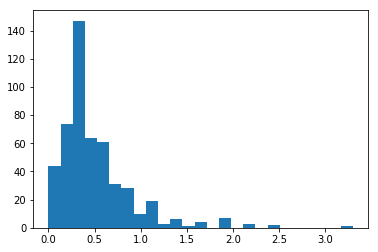

In [25]:
_=plt.hist(dfSynAll_C.Dn_s,25)

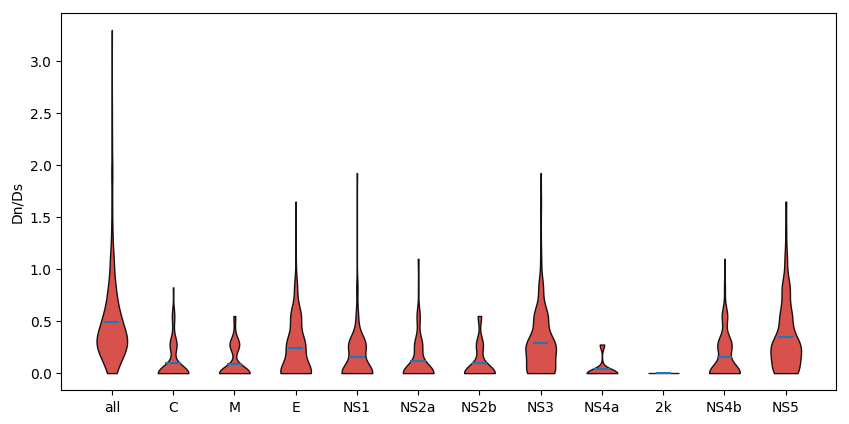

In [26]:
fig = plt.figure(figsize=(10, 5), dpi=100)

parts = plt.violinplot([dfSynAll_C.Dn_s.values, dfSynC_C.Dn_s.values, dfSynM_C.Dn_s.values, dfSynE_C.Dn_s.values, \
                dfSynNS1_C.Dn_s.values, dfSynNS2a_C.Dn_s.values, dfSynNS2b_C.Dn_s.values, \
                  dfSynNS3_C.Dn_s.values, dfSynNS4a_C.Dn_s.values, dfSyn2k_C.Dn_s.values, \
                  dfSynNS4b_C.Dn_s.values, dfSynNS5_C.Dn_s.values], showextrema=False, showmeans=True)

for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(0.9)
  
_=plt.xticks(range(1,13), ['all', 'C', 'M', 'E', 'NS1','NS2a', 'NS2b', 'NS3','NS4a','2k','NS4b','NS5'])
_=plt.ylabel('Dn/Ds')
# labels = ['A', 'B', 'C', 'D']
# set_axis_style(fig, labels)

In [8]:
dfSynAll_C.Dn_s.max()

3.3000894266524168

In [9]:
dfSynAll_C.loc[dfSynAll_C['Dn_s'].idxmax()]

ID           vars1001700603_F17.vcf
numSyn                            1
numNonSyn                        12
numStop                           0
Ds                      0.000455996
Dn                       0.00150483
Dn_s                        3.30009
Name: 251, dtype: object

In [21]:
dfSynAll_C.head()

,name,ID,numSyn,numNonSyn,numStop,Ds,Dn,Dn_s
82,1001700602_A6,vars1001700602_A6.vcf,1,0,0,0.000456,-0.000000,-0.000000
175,1001700602_N16,vars1001700602_N16.vcf,1,0,0,0.000456,-0.000000,-0.000000
202,1001700603_A16,vars1001700603_A16.vcf,1,3,0,0.000456,0.000376,0.824402
203,1001700603_A17,vars1001700603_A17.vcf,1,6,0,0.000456,0.000752,1.649217
204,1001700603_A19,vars1001700603_A19.vcf,4,5,0,0.001826,0.000627,0.343245


In [22]:
%store dfSynAll_C

Stored 'dfSynAll_C' (DataFrame)


In [23]:
len(dfSynAll_C)

505